In [1]:
import os
import keras
import logging
import numpy as np
from imageio import imread
from keras.models import Model
import matplotlib.pyplot as plt
from keras.regularizers import l2
from keras.optimizers import Adam
from PIL import Image, ImageFilter
from keras.models import Sequential
from keras.engine.topology import Layer
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Lambda, Flatten, Dense
from keras.layers.normalization import BatchNormalization
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate

%matplotlib inline
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

Using TensorFlow backend.


### Dataset managment

In [2]:
def download_ds(download_address, save_address):
    if os.path.exists(save_address):
        logger.info("The dataset has already been downloaded.")
    else:
        !wget -O ds.zip {download_address}
        !unzip ds.zip
        !mv ShapesData_few-show-learning {save_address}
        !find {save_address} -name '*.DS_Store' -delete

In [3]:
class DS:
    def __init__(self):
        self.x_tr = None
        self.y_tr = None
        self.labels_tr = None
        self.x_val = None
        self.Y_val = None
        self.labels_val = None
        self.x_eval = None
        self.y_eval = None
        self.labels_eval = None
        self.names_tr = []
        self.names_val = []
        self.names_eval = []
        #self.labels_dict = None

    def __Load_data(self,address, new_im_size, train_ratio,channel_type="RGB"):
        class_count = len(os.listdir(address))
        train_count = int(class_count*train_ratio)
        train_idx = np.random.choice(class_count, size = train_count, replace = False)
        x_tr, y_tr, x_val, y_val, names_tr, names_val = [],[],[],[], [], []
        #labels_idx = dict()
        labels_tr = []
        labels_val = []
        offset_tr, offset_val = 0,0
        if os.path.exists(os.path.join(address,".DS_Store")):
            os.remove(os.path.join(address, ".DS_Store"))
        for i , label in enumerate(os.listdir(address)):
            labels_address = os.path.join(address, label)
            x, y, labels, names = (x_tr, y_tr, labels_tr, names_tr) if i in train_idx else (x_val, y_val, labels_val, names_val)
            #labels_idx[i] = label
            for image_name in os.listdir(labels_address):
                image_address = os.path.join(labels_address, image_name)
                try:
                    img = Image.open(image_address).convert(channel_type)
                    img = img.resize((new_im_size, new_im_size))
                    x.append(np.array(img, dtype=np.float32))
                    y.append(i)
                except:
                    logger.info("ERROR: can't load {}".format(image_address))
            label_count = len(os.listdir(labels_address))
            names.append(label)
            if i in train_idx:
                labels.append((i, label_count , offset_tr))
                offset_tr+=label_count
            else:
                labels.append((i, label_count , offset_val))
                offset_val+=label_count

        x_tr = np.array(x_tr)
        y_tr = np.array(y_tr)
                
        x_val = np.array(x_val)
        y_val = np.array(y_val)

        if class_count-train_count > 0:
            x_val = np.array(x_val)
            y_val = np.array(y_val)

        return x_tr, y_tr, np.array(labels_tr), names_tr, x_val, y_val, np.array(labels_val), names_val

    def Load_evaluation(self, address, new_im_size,channel_type="RGB"):
        self.x_eval, self.eval, self.labels_eval,self.names_eval, _, _, _, _ =self.__Load_data(address, new_im_size, 1, channel_type)

    def Load_background(self,address, new_im_size, train_ratio, channel_type="RGB"):
        self.x_tr, self.y_tr, self.labels_tr,self.names_tr, self.x_val, self.y_val, self.labels_val, self.names_val=self.__Load_data(address, new_im_size, train_ratio, channel_type)
    
    def get_paired_data(self,batch_size, x, labels):
        half_size = batch_size // 2
        class_count = labels.shape[0]
        rnd_classes = np.random.choice(class_count, size = half_size, replace = True)
        rnd_pos_classes_lbl =labels[rnd_classes]
        rnd_1 = (np.random.uniform(0,1, half_size)*rnd_pos_classes_lbl[:,1]+rnd_pos_classes_lbl[:,2]).astype(np.int32)
        rnd_pos_2 = (np.random.uniform(0,1, half_size)*rnd_pos_classes_lbl[:,1] +rnd_pos_classes_lbl[:,2]).astype(np.int32)

        rnd_neg_2_classes =  (rnd_classes + np.random.randint(1,class_count-1,half_size)) % class_count
        rnd_neg_classes_lbl =labels[rnd_neg_2_classes]
        rnd_neg_2 = (np.random.uniform(0,1, half_size)*rnd_neg_classes_lbl[:,1]+rnd_neg_classes_lbl[:,2]).astype(np.int32)

        pair_1 = x[np.repeat(rnd_1,2)]
        pair_2 = np.concatenate((x[rnd_pos_2], x[rnd_neg_2]))
        y = np.ones(half_size*2)
        y[half_size:]= 0
        return [pair_1, pair_2], y

    def get_paired_train(self, batch_size):
        while True:
            yield self.get_paired_data(batch_size, self.x_tr, self.labels_tr)

    def get_paired_val(self, batch_size):
        while True:
            return self.get_paired_data(batch_size, self.x_val, self.labels_val)
    
    def get_paired_one_shot_eval(self,x, labels, class_idx):
        class_count = labels.shape[0]
        class_spec = labels[class_idx]
        pair_1 = np.zeros((class_count, x.shape[1], x.shape[2], x.shape[3]))
        pair_2 = np.zeros((class_count, x.shape[1], x.shape[2], x.shape[3]))
        rnd1 = (np.random.uniform(0,1, 1)*class_spec[1]+class_spec[2]).astype(np.int32)
        rnd1_repeated = np.repeat(rnd1, class_count)
        pair_1[:,:,:,:] = x[rnd1_repeated]
        classes = np.arange(class_count)
        rnd2 = (np.random.uniform(0,1, class_count)*labels[:,1]+labels[:,2]).astype(np.int32)
        pair_2[:,:,:,:] = x[rnd2]
        
        y = np.zeros(class_count)
        y[class_idx] = 1
        return [pair_1, pair_2], y  
        
    def normalize(self):
        self.x_tr= self.x_tr /255
        self.x_val= self.x_val / 255
        self.x_eval= self.x_eval / 255

    def standardize_images(self,x):
        if x is None:
            return None
        means = np.mean(x, axis=0)
        stds = np.std(x, axis=0)
        return (x-means)/stds

    def standardize_ds(self):
        self.x_tr = self.standardize_images(self.x_tr)
        self.x_val = self.standardize_images(self.x_val)
        self.x_eval = self.standardize_images(self.x_eval)

    def reshape(self):
        if self.x_tr is not None and len(self.x_tr.shape)<4:
            self.x_tr = self.x_tr.reshape(*self.x_tr.shape,1)
        if self.x_eval is not None and len(self.x_eval.shape)<4:
            self.x_eval = self.x_eval.reshape(*self.x_eval.shape,1)
        if self.x_val is not None and len(self.x_val.shape)<4:
            self.x_val = self.x_val.reshape(*self.x_val.shape,1)

    def remove_from_train(self):
        name = self.names_tr[-1]
        self.names_tr = self.names_tr[:-1]
        _, length, offset = self.labels_tr[-1]
        self.labels_tr = self.labels_tr[:-1]
        self.x_tr = self.x_tr[:offset]
        self.y_tr = self.y_tr[:offset]
        return name


### Model

In [4]:
def siamese(input_shape):
    init_b = keras.initializers.RandomNormal(mean = 0.5, stddev=0.01)
    init_w = keras.initializers.RandomNormal(mean = 0.0, stddev=0.01)
    model = Sequential()
    model.add(Conv2D(64, (10,10), activation='relu', input_shape=input_shape,kernel_initializer=init_w, bias_initializer=init_b, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (7,7), activation='relu', kernel_initializer=init_w, bias_initializer=init_b, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4,4), activation='relu', kernel_initializer=init_w, bias_initializer=init_b, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (4,4), activation='relu', kernel_initializer=init_w, bias_initializer=init_b, kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid',kernel_regularizer=l2(1e-3), kernel_initializer=init_w,bias_initializer=init_b))
    dense_layer = Dense(1,activation='sigmoid',bias_initializer=init_b)
    L1_layer = Lambda(lambda tensors:keras.backend.abs(tensors[0] - tensors[1]))
    input_1, input_2 = Input(input_shape), Input(input_shape)
    outputs = dense_layer(L1_layer([model(input_1), model(input_2)]))
    siamese_model = Model(inputs=[input_1,input_2],outputs=outputs)
    return siamese_model


In [ ]:
'''
print(batch1_ds.labels)
print(batch1_ds.x_tr.shape)
print(batch1_ds.y_tr.shape)
print(batch1_ds.labels_tr)
print(batch1_ds.x_val.shape)
print(batch1_ds.y_val.shape)
print(batch1_ds.labels_val)
'''

'\nprint(batch1_ds.labels)\nprint(batch1_ds.x_tr.shape)\nprint(batch1_ds.y_tr.shape)\nprint(batch1_ds.labels_tr)\nprint(batch1_ds.x_val.shape)\nprint(batch1_ds.y_val.shape)\nprint(batch1_ds.labels_val)\n'

In [5]:
def load_evaluation_folder(address, new_im_size, channel_type="RGB"):
    ds_list = []
    for file_name in os.listdir(address):
        folder_address = os.path.join(address, file_name)
        for folder_name in os.listdir(folder_address):
            ds = DS()
            ds.Load_evaluation(os.path.join(folder_address, folder_name),new_im_size, channel_type)
            ds.reshape()
            ds_list.append([ds,file_name+'/'+folder_name])
    return ds_list

In [6]:
def eval_siamese(model,ds, count):
    class_count = ds.labels_eval.shape[0]
    corrects = np.zeros(class_count)
    per_class = np.zeros(class_count)

    #corrects_knn = np.zeros(class_count)
    
    for i in range(count):
        pairs, y = ds.get_paired_one_shot_eval(ds.x_eval, ds.labels_eval, i%class_count)
        predictions = model.predict(pairs)
        
        corrects[i%class_count] += np.argmax(predictions) == np.argmax(y)
        per_class[i%class_count] += 1

        #corrects_knn += nearest_neighbour(pairs, y)

    acc = corrects/per_class
    return acc, np.average(acc)

In [7]:
def evaluate_list(model, ds_list, count):
    for ds, name in ds_list:
        acc, acc_avg = eval_siamese(model,ds, count)
        print("______________________________")
        print("Evaluation for {}: average accuracy={}".format(name, acc_avg))
        for i, label in enumerate(ds.names_eval):
            print("the accuracy for {}: {}".format(label, acc[i]))

In [8]:
def plot_history(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

### Experiment 1: Batch1


Download and load

In [10]:
bg_download_address = "https://www.dropbox.com/s/9imgl9m0qzin55g/ShapesData_few-show-learning.zip?dl=0"
bg_save_address = "dataset"
eval_download_address = "https://www.dropbox.com/s/bhk86noqwollrs9/new_data.zip?dl=1"
eval_save_address = "new_data"
new_im_size = 105
download_ds(bg_download_address, bg_save_address)
download_ds(eval_download_address, eval_save_address)
batch1_address = os.path.join(bg_save_address, "batch1")
batch1_ds = DS()
batch1_ds.Load_background(batch1_address, 105, 0.7)
eval_list = load_evaluation_folder(eval_save_address, new_im_size)

#batch1_ds.normalize()
#batch1_ds.standardize_ds()

Creating the model

In [ ]:
model = siamese((new_im_size, new_im_size, 3))
model.summary()
optimizer = Adam(lr = 0.00006)

model.compile(loss="binary_crossentropy",optimizer=optimizer)

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 105, 105, 3)  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 105, 105, 3)  0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 4096)         38960448    input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 4096)         0           sequential_1[1][0]         

Train

In [ ]:
batch_size = 20
cb = [EarlyStopping(min_delta=0.0005, patience=150)]
history =model.fit_generator(generator=batch1_ds.get_paired_train(batch_size),steps_per_epoch=1, epochs = 2000,\
                    validation_data = batch1_ds.get_paired_val(batch_size), validation_steps = 10, callbacks= cb)

Epoch 1/2000
1/1 [==============================] - 2s 2s/step - loss: 4.5223 - val_loss: 4.5128
Epoch 2/2000
1/1 [==============================] - 0s 146ms/step - loss: 4.5009 - val_loss: 4.4969
Epoch 3/2000
1/1 [==============================] - 0s 144ms/step - loss: 4.4664 - val_loss: 4.4903
Epoch 4/2000
1/1 [==============================] - 0s 150ms/step - loss: 4.4927 - val_loss: 4.4556
Epoch 5/2000
1/1 [==============================] - 0s 145ms/step - loss: 4.3984 - val_loss: 4.4393
Epoch 6/2000
1/1 [==============================] - 0s 149ms/step - loss: 4.4514 - val_loss: 4.4250
Epoch 7/2000
1/1 [==============================] - 0s 145ms/step - loss: 4.4301 - val_loss: 4.4080
Epoch 8/2000
1/1 [==============================] - 0s 145ms/step - loss: 4.4032 - val_loss: 4.3946
Epoch 9/2000
1/1 [==============================] - 0s 147ms/step - loss: 4.4630 - val_loss: 4.3734
Epoch 10/2000
1/1 [==============================] - 0s 144ms/step - loss: 4.4101 - val_loss: 4.3589
Ep

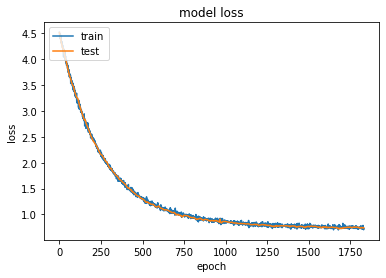

In [ ]:
plot_history(history)

Evaluation

In [ ]:
evaluate_list(model, eval_list, 100)

______________________________
Evaluation for naturale/camera: average accuracy=0.6499999999999999
the accuracy for tree: 0.9
the accuracy for bat: 0.3
the accuracy for monkey: 0.7
the accuracy for house: 0.4
the accuracy for girl: 0.9
the accuracy for car: 0.6
the accuracy for if: 1.0
the accuracy for boy: 0.8
the accuracy for crocodile: 0.3
the accuracy for lion: 0.6
______________________________
Evaluation for naturale/cellulare: average accuracy=0.48
the accuracy for tree: 0.7
the accuracy for bat: 0.2
the accuracy for monkey: 0.6
the accuracy for house: 0.2
the accuracy for girl: 0.5
the accuracy for car: 0.3
the accuracy for if: 1.0
the accuracy for boy: 0.4
the accuracy for crocodile: 0.3
the accuracy for lion: 0.6
______________________________
Evaluation for artificiale/camera: average accuracy=0.7
the accuracy for tree: 0.5
the accuracy for bat: 0.5
the accuracy for monkey: 0.8
the accuracy for house: 0.7
the accuracy for girl: 0.8
the accuracy for car: 0.5
the accuracy for 

### Experiment 2: Batch2

Loading the data

In [11]:
new_im_size = 105
batch2_address = os.path.join(bg_save_address, "batch2_gray")
batch2_ds = DS()
batch2_ds.Load_background(batch2_address, 105, 0.7, "L")
batch2_ds.reshape()
eval_list_gray = load_evaluation_folder(eval_save_address, new_im_size,"L")

creating a new model

In [ ]:
model2 = siamese((new_im_size, new_im_size, 1))
model2.summary()
optimizer2 = Adam(lr = 0.00006)
model2.compile(loss="binary_crossentropy",optimizer=optimizer2)

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 105, 105, 1)  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 105, 105, 1)  0                                            
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 4096)         38947648    input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 4096)         0           sequential_2[1][0]         

In [ ]:
batch_size = 20
cb = [EarlyStopping(min_delta=0.0005, patience=150)]
history2 =model2.fit_generator(generator=batch2_ds.get_paired_train(batch_size),steps_per_epoch=1, epochs = 2000,\
                    validation_data = batch2_ds.get_paired_val(batch_size), validation_steps = 10, callbacks= cb)

Epoch 1/2000
1/1 [==============================] - 1s 715ms/step - loss: 4.5286 - val_loss: 4.5098
Epoch 2/2000
1/1 [==============================] - 0s 137ms/step - loss: 4.5163 - val_loss: 4.5022
Epoch 3/2000
1/1 [==============================] - 0s 144ms/step - loss: 4.5060 - val_loss: 4.4900
Epoch 4/2000
1/1 [==============================] - 0s 138ms/step - loss: 4.4593 - val_loss: 4.4724
Epoch 5/2000
1/1 [==============================] - 0s 138ms/step - loss: 4.4548 - val_loss: 4.4547
Epoch 6/2000
1/1 [==============================] - 0s 136ms/step - loss: 4.4650 - val_loss: 4.4284
Epoch 7/2000
1/1 [==============================] - 0s 137ms/step - loss: 4.4301 - val_loss: 4.4077
Epoch 8/2000
1/1 [==============================] - 0s 135ms/step - loss: 4.4163 - val_loss: 4.3878
Epoch 9/2000
1/1 [==============================] - 0s 136ms/step - loss: 4.3677 - val_loss: 4.3720
Epoch 10/2000
1/1 [==============================] - 0s 135ms/step - loss: 4.3556 - val_loss: 4.3665

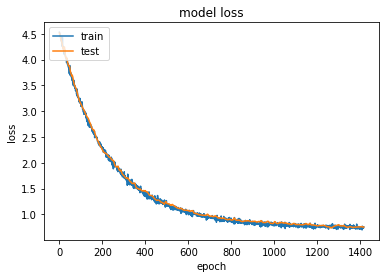

In [ ]:
plot_history(history2)

Evaluate

In [ ]:
evaluate_list(model2, eval_list_gray, 100)

______________________________
Evaluation for naturale/camera: average accuracy=0.7699999999999999
the accuracy for tree: 1.0
the accuracy for bat: 0.7
the accuracy for monkey: 0.9
the accuracy for house: 0.7
the accuracy for girl: 0.9
the accuracy for car: 0.5
the accuracy for if: 0.9
the accuracy for boy: 0.7
the accuracy for crocodile: 0.6
the accuracy for lion: 0.8
______________________________
Evaluation for naturale/cellulare: average accuracy=0.6100000000000001
the accuracy for tree: 0.9
the accuracy for bat: 0.6
the accuracy for monkey: 0.7
the accuracy for house: 0.5
the accuracy for girl: 0.8
the accuracy for car: 0.5
the accuracy for if: 0.9
the accuracy for boy: 0.4
the accuracy for crocodile: 0.4
the accuracy for lion: 0.4
______________________________
Evaluation for artificiale/camera: average accuracy=0.7100000000000001
the accuracy for tree: 0.9
the accuracy for bat: 0.3
the accuracy for monkey: 0.8
the accuracy for house: 0.4
the accuracy for girl: 1.0
the accuracy f

### Experiment 3: Batch1 as grayscale

In [ ]:
batch1_gray_ds = DS()
batch1_gray_ds.Load_background(batch1_address, 105, 0.7,"L")
batch1_gray_ds.reshape()

In [ ]:
model1_gray = siamese((new_im_size, new_im_size, 1))
model1_gray.summary()
optimizer = Adam(lr = 0.00006)
model1_gray.compile(loss="binary_crossentropy",optimizer=optimizer)

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 105, 105, 1)  0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 105, 105, 1)  0                                            
__________________________________________________________________________________________________
sequential_3 (Sequential)       (None, 4096)         38947648    input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
lambda_3 (Lambda)               (None, 4096)         0           sequential_3[1][0]         

In [ ]:
batch_size = 20
cb = [EarlyStopping(min_delta=0.0005, patience=150)]
history1_gray =model1_gray.fit_generator(generator=batch1_gray_ds.get_paired_train(batch_size),steps_per_epoch=1, epochs = 2000,\
                    validation_data = batch1_gray_ds.get_paired_val(batch_size), validation_steps = 10, callbacks= cb)

Epoch 1/2000
1/1 [==============================] - 1s 669ms/step - loss: 4.5290 - val_loss: 4.5192
Epoch 2/2000
1/1 [==============================] - 0s 141ms/step - loss: 4.5072 - val_loss: 4.5069
Epoch 3/2000
1/1 [==============================] - 0s 136ms/step - loss: 4.4884 - val_loss: 4.4945
Epoch 4/2000
1/1 [==============================] - 0s 136ms/step - loss: 4.4385 - val_loss: 4.4810
Epoch 5/2000
1/1 [==============================] - 0s 137ms/step - loss: 4.4482 - val_loss: 4.4637
Epoch 6/2000
1/1 [==============================] - 0s 136ms/step - loss: 4.4452 - val_loss: 4.4505
Epoch 7/2000
1/1 [==============================] - 0s 135ms/step - loss: 4.4224 - val_loss: 4.4386
Epoch 8/2000
1/1 [==============================] - 0s 135ms/step - loss: 4.4467 - val_loss: 4.4159
Epoch 9/2000
1/1 [==============================] - 0s 135ms/step - loss: 4.3862 - val_loss: 4.3997
Epoch 10/2000
1/1 [==============================] - 0s 136ms/step - loss: 4.4286 - val_loss: 4.3809

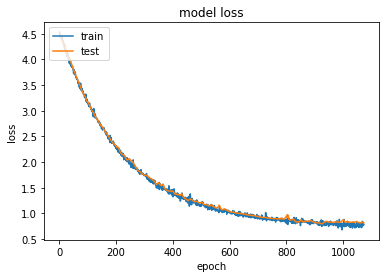

In [ ]:
plot_history(history1_gray)

In [ ]:
evaluate_list(model1_gray, eval_list_gray, 100)

______________________________
Evaluation for naturale/camera: average accuracy=0.29
the accuracy for tree: 0.1
the accuracy for bat: 0.2
the accuracy for monkey: 0.6
the accuracy for house: 0.3
the accuracy for girl: 0.4
the accuracy for car: 0.1
the accuracy for if: 0.3
the accuracy for boy: 0.4
the accuracy for crocodile: 0.1
the accuracy for lion: 0.4
______________________________
Evaluation for naturale/cellulare: average accuracy=0.30000000000000004
the accuracy for tree: 0.1
the accuracy for bat: 0.4
the accuracy for monkey: 0.5
the accuracy for house: 0.1
the accuracy for girl: 0.5
the accuracy for car: 0.2
the accuracy for if: 0.4
the accuracy for boy: 0.2
the accuracy for crocodile: 0.2
the accuracy for lion: 0.4
______________________________
Evaluation for artificiale/camera: average accuracy=0.31
the accuracy for tree: 0.2
the accuracy for bat: 0.1
the accuracy for monkey: 0.8
the accuracy for house: 0.2
the accuracy for girl: 0.2
the accuracy for car: 0.0
the accuracy fo

### Experiment 4: 1NN

In [37]:
def nearest_neighbour(ds, count):
    class_count = ds.labels_eval.shape[0]
    corrects = np.zeros(class_count)
    per_class = np.zeros(class_count)
    for i in range(count):

        pairs, y = ds.get_paired_one_shot_eval(ds.x_eval, ds.labels_eval, i%class_count)
        predictions = np.linalg.norm(np.linalg.norm(pairs[0]-pairs[1], axis=(1,2)), axis=1)
        corrects[i%class_count] += np.argmin(predictions) == np.argmax(y)
        per_class[i%class_count] += 1

    acc = corrects/per_class
    return acc, np.average(acc)
def knn_accuracy(ds_list,count):
    for ds, name in ds_list:
        acc, acc_avg = nearest_neighbour(ds, count)
        print("______________________________")
        print("Evaluation for {} Nearest Neighbour average acc={}".format(name, acc_avg))
        for i, label in enumerate(ds.names_eval):
            print("the accuracy for {}: {}".format(label, acc[i]))

In [38]:
knn_accuracy(eval_list,1000)

______________________________
Evaluation for artificiale/cellulare Nearest Neighbour average acc=0.53
the accuracy for girl: 0.47
the accuracy for crocodile: 0.35
the accuracy for boy: 0.55
the accuracy for house: 0.36
the accuracy for monkey: 0.73
the accuracy for bat: 0.6
the accuracy for lion: 0.62
the accuracy for car: 0.46
the accuracy for tree: 0.49
the accuracy for if: 0.67
______________________________
Evaluation for artificiale/camera Nearest Neighbour average acc=0.6930000000000001
the accuracy for girl: 0.75
the accuracy for crocodile: 0.67
the accuracy for boy: 0.71
the accuracy for house: 0.63
the accuracy for monkey: 0.86
the accuracy for bat: 0.64
the accuracy for lion: 0.65
the accuracy for car: 0.63
the accuracy for tree: 0.57
the accuracy for if: 0.82
______________________________
Evaluation for flash/cellulare Nearest Neighbour average acc=0.466
the accuracy for girl: 0.36
the accuracy for crocodile: 0.41
the accuracy for boy: 0.4
the accuracy for house: 0.42
the 

### Experiment 5: Augmented Batch1

In [ ]:
augmented_address = "https://www.dropbox.com/s/12lq4gqu9qjqn1v/aug.zip?dl=1"
if not os.path.exists('augmented_batch1'):
    !wget -O ds.zip {augmented_address}
    !unzip ds.zip
    !mv batch1 augmented_batch1
    !mv batch2_gray augmented_batch2
aug_batch1_ds = DS()
aug_batch1_ds.Load_background("augmented_batch1", 105, 0.7)

Streaming output truncated to the last 5000 lines.
  inflating: batch1/Lion/Lion_Green_Artificial_0_frame153.jpg  
  inflating: batch1/Lion/Lion_Green_Artificial_0_frame153_augm_0.jpg  
  inflating: batch1/Lion/Lion_Green_Artificial_0_frame154.jpg  
  inflating: batch1/Lion/Lion_Green_Artificial_0_frame154_augm_0.jpg  
  inflating: batch1/Lion/Lion_Green_Artificial_0_frame155.jpg  
  inflating: batch1/Lion/Lion_Green_Artificial_0_frame155_augm_0.jpg  
  inflating: batch1/Lion/Lion_Green_Artificial_0_frame156.jpg  
  inflating: batch1/Lion/Lion_Green_Artificial_0_frame156_augm_0.jpg  
  inflating: batch1/Lion/Lion_Green_Artificial_0_frame157.jpg  
  inflating: batch1/Lion/Lion_Green_Artificial_0_frame157_augm_0.jpg  
  inflating: batch1/Lion/Lion_Green_Artificial_0_frame158.jpg  
  inflating: batch1/Lion/Lion_Green_Artificial_0_frame158_augm_0.jpg  
  inflating: batch1/Lion/Lion_Green_Artificial_0_frame159.jpg  
  inflating: batch1/Lion/Lion_Green_Artificial_0_frame159_augm_0.jpg  
  in

In [ ]:
model_aug1 = siamese((new_im_size, new_im_size, 3))
model_aug1.summary()
optimizer = Adam(lr = 0.00006)

model_aug1.compile(loss="binary_crossentropy",optimizer=optimizer)

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 105, 105, 3)  0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            (None, 105, 105, 3)  0                                            
__________________________________________________________________________________________________
sequential_4 (Sequential)       (None, 4096)         38960448    input_7[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
lambda_4 (Lambda)               (None, 4096)         0           sequential_4[1][0]         

In [ ]:
batch_size = 20
cb = [EarlyStopping(min_delta=0.0005, patience=150)]
history_aug1 =model_aug1.fit_generator(generator=aug_batch1_ds.get_paired_train(batch_size),steps_per_epoch=1, epochs = 4000,\
                    validation_data = aug_batch1_ds.get_paired_val(batch_size), validation_steps = 10)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 146ms/step - loss: 0.8549 - val_loss: 0.7907
Epoch 1502/4000
1/1 [==============================] - 0s 146ms/step - loss: 0.7863 - val_loss: 0.7888
Epoch 1503/4000
1/1 [==============================] - 0s 145ms/step - loss: 0.8280 - val_loss: 0.7881
Epoch 1504/4000
1/1 [==============================] - 0s 144ms/step - loss: 0.8077 - val_loss: 0.7915
Epoch 1505/4000
1/1 [==============================] - 0s 144ms/step - loss: 0.7956 - val_loss: 0.7933
Epoch 1506/4000
1/1 [==============================] - 0s 144ms/step - loss: 0.8086 - val_loss: 0.7945
Epoch 1507/4000
1/1 [==============================] - 0s 144ms/step - loss: 0.8126 - val_loss: 0.7956
Epoch 1508/4000
1/1 [==============================] - 0s 143ms/step - loss: 0.8312 - val_loss: 0.7959
Epoch 1509/4000
1/1 [==============================] - 0s 144ms/step - loss: 0.8203 - val_loss: 0.7951
Epoch 1510/4000
1/1 [=================

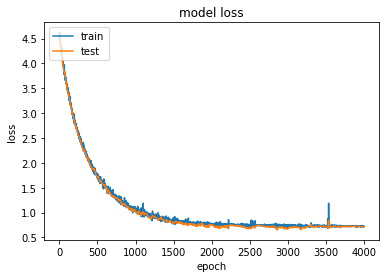

In [ ]:
plot_history(history_aug1)

In [ ]:
evaluate_list(model_aug1, eval_list, 100)

______________________________
Evaluation for naturale/camera: average accuracy=0.23000000000000004
the accuracy for tree: 0.0
the accuracy for bat: 0.3
the accuracy for monkey: 0.3
the accuracy for house: 0.1
the accuracy for girl: 0.4
the accuracy for car: 0.3
the accuracy for if: 0.3
the accuracy for boy: 0.2
the accuracy for crocodile: 0.2
the accuracy for lion: 0.2
______________________________
Evaluation for naturale/cellulare: average accuracy=0.30999999999999994
the accuracy for tree: 0.3
the accuracy for bat: 0.3
the accuracy for monkey: 0.5
the accuracy for house: 0.2
the accuracy for girl: 0.2
the accuracy for car: 0.3
the accuracy for if: 0.3
the accuracy for boy: 0.6
the accuracy for crocodile: 0.1
the accuracy for lion: 0.3
______________________________
Evaluation for artificiale/camera: average accuracy=0.36
the accuracy for tree: 0.3
the accuracy for bat: 0.2
the accuracy for monkey: 0.7
the accuracy for house: 0.3
the accuracy for girl: 0.6
the accuracy for car: 0.3


### Experiment 6: Augmented Batch2

In [ ]:
aug_batch2_ds = DS()
aug_batch2_ds.Load_background("augmented_batch2", 105, 0.7, "L")
aug_batch2_ds.reshape()

In [ ]:
model_aug2 = siamese((new_im_size, new_im_size, 1))
model_aug2.summary()
optimizer = Adam(lr = 0.00006)

model_aug2.compile(loss="binary_crossentropy",optimizer=optimizer)

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 105, 105, 1)  0                                            
__________________________________________________________________________________________________
input_10 (InputLayer)           (None, 105, 105, 1)  0                                            
__________________________________________________________________________________________________
sequential_5 (Sequential)       (None, 4096)         38947648    input_9[0][0]                    
                                                                 input_10[0][0]                   
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, 4096)         0           sequential_5[1][0]         

In [ ]:
batch_size = 20
cb = [EarlyStopping(min_delta=0.0005, patience=300)]
history_aug2 =model_aug2.fit_generator(generator=aug_batch2_ds.get_paired_train(batch_size),steps_per_epoch=1, epochs = 3000,\
                    validation_data = aug_batch2_ds.get_paired_val(batch_size), validation_steps = 10, callbacks =cb)

Epoch 1/3000
1/1 [==============================] - 1s 520ms/step - loss: 4.5282 - val_loss: 4.5319
Epoch 2/3000
1/1 [==============================] - 0s 136ms/step - loss: 4.5123 - val_loss: 4.5400
Epoch 3/3000
1/1 [==============================] - 0s 134ms/step - loss: 4.4332 - val_loss: 4.5656
Epoch 4/3000
1/1 [==============================] - 0s 136ms/step - loss: 4.4526 - val_loss: 4.5482
Epoch 5/3000
1/1 [==============================] - 0s 135ms/step - loss: 4.4861 - val_loss: 4.4837
Epoch 6/3000
1/1 [==============================] - 0s 137ms/step - loss: 4.4449 - val_loss: 4.4633
Epoch 7/3000
1/1 [==============================] - 0s 139ms/step - loss: 4.4684 - val_loss: 4.4557
Epoch 8/3000
1/1 [==============================] - 0s 135ms/step - loss: 4.4350 - val_loss: 4.4493
Epoch 9/3000
1/1 [==============================] - 0s 135ms/step - loss: 4.4100 - val_loss: 4.4463
Epoch 10/3000
1/1 [==============================] - 0s 135ms/step - loss: 4.4565 - val_loss: 4.4360

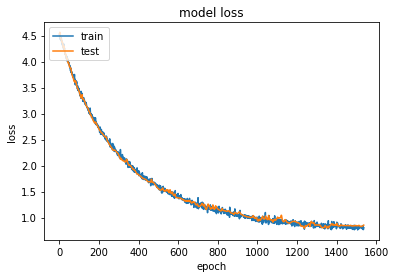

In [ ]:
plot_history(history_aug2)

In [ ]:
evaluate_list(model_aug2, eval_list_gray, 100)

______________________________
Evaluation for naturale/camera: average accuracy=0.49000000000000005
the accuracy for tree: 0.6
the accuracy for bat: 0.4
the accuracy for monkey: 0.8
the accuracy for house: 0.4
the accuracy for girl: 0.3
the accuracy for car: 0.7
the accuracy for if: 1.0
the accuracy for boy: 0.2
the accuracy for crocodile: 0.2
the accuracy for lion: 0.3
______________________________
Evaluation for naturale/cellulare: average accuracy=0.4499999999999999
the accuracy for tree: 0.9
the accuracy for bat: 0.3
the accuracy for monkey: 0.6
the accuracy for house: 0.3
the accuracy for girl: 0.2
the accuracy for car: 0.2
the accuracy for if: 0.8
the accuracy for boy: 0.4
the accuracy for crocodile: 0.5
the accuracy for lion: 0.3
______________________________
Evaluation for artificiale/camera: average accuracy=0.5599999999999999
the accuracy for tree: 0.7
the accuracy for bat: 0.1
the accuracy for monkey: 0.9
the accuracy for house: 0.2
the accuracy for girl: 0.5
the accuracy 

### Experiment 7: One Shot
In the provided dataset all the classes are present in both new-data and train-data. Here we tried to keep a class only for evaluation.

In [ ]:
one_shot_ds = DS()
one_shot_ds.Load_background(batch2_address, 105, 0.7, "L")
one_shot_ds.reshape()
name = one_shot_ds.remove_from_train()
print("{} has been removed from the training set.".format(name))

Car has been removed from the training set.


In [ ]:
one_shot_model = siamese((new_im_size, new_im_size, 1))
one_shot_model.compile(loss="binary_crossentropy",optimizer=optimizer2)


In [ ]:
batch_size = 20
cb = [EarlyStopping(min_delta=0.0005, patience=150)]
history_one =one_shot_model.fit_generator(generator=one_shot_ds.get_paired_train(batch_size),steps_per_epoch=1, epochs = 2000,\
                    validation_data = one_shot_ds.get_paired_val(batch_size), validation_steps = 10, callbacks= cb)

Epoch 1/2000
1/1 [==============================] - 1s 554ms/step - loss: 4.5222 - val_loss: 4.4554
Epoch 2/2000
1/1 [==============================] - 0s 135ms/step - loss: 4.4692 - val_loss: 4.3571
Epoch 3/2000
1/1 [==============================] - 0s 136ms/step - loss: 4.5278 - val_loss: 4.3935
Epoch 4/2000
1/1 [==============================] - 0s 143ms/step - loss: 4.3714 - val_loss: 4.2511
Epoch 5/2000
1/1 [==============================] - 0s 139ms/step - loss: 4.2472 - val_loss: 4.2045
Epoch 6/2000
1/1 [==============================] - 0s 136ms/step - loss: 4.1866 - val_loss: 4.1518
Epoch 7/2000
1/1 [==============================] - 0s 135ms/step - loss: 4.1123 - val_loss: 4.0021
Epoch 8/2000
1/1 [==============================] - 0s 135ms/step - loss: 4.0950 - val_loss: 3.9238
Epoch 9/2000
1/1 [==============================] - 0s 134ms/step - loss: 3.9879 - val_loss: 3.8584
Epoch 10/2000
1/1 [==============================] - 0s 135ms/step - loss: 3.8394 - val_loss: 3.7644

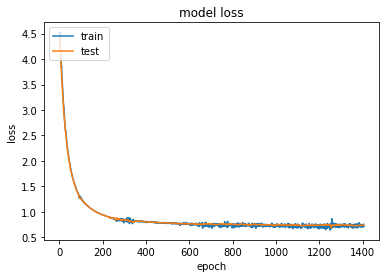

In [ ]:
plot_history(history_one)

In [ ]:
print("#"*10)
print("The following class was removed from the training set: ", name)
print("#"*10)
evaluate_list(one_shot_model, eval_list_gray, 100)

##########
The following class was removed from the training set:  Car
##########
______________________________
Evaluation for naturale/camera: average accuracy=0.41
the accuracy for tree: 0.1
the accuracy for bat: 0.3
the accuracy for monkey: 0.4
the accuracy for house: 0.7
the accuracy for girl: 0.9
the accuracy for car: 0.5
the accuracy for if: 1.0
the accuracy for boy: 0.0
the accuracy for crocodile: 0.2
the accuracy for lion: 0.0
______________________________
Evaluation for naturale/cellulare: average accuracy=0.26
the accuracy for tree: 0.4
the accuracy for bat: 0.0
the accuracy for monkey: 0.3
the accuracy for house: 0.2
the accuracy for girl: 0.2
the accuracy for car: 0.3
the accuracy for if: 1.0
the accuracy for boy: 0.1
the accuracy for crocodile: 0.1
the accuracy for lion: 0.0
______________________________
Evaluation for artificiale/camera: average accuracy=0.45999999999999996
the accuracy for tree: 0.8
the accuracy for bat: 0.3
the accuracy for monkey: 0.4
the accuracy f